In [25]:
import pandas as pd
import numpy as np
import os
from scipy.stats import fisher_exact
import json

# Load data

In [2]:
import pickle
infile = open("interaction_data.pkl",'rb')
d = pickle.load(infile)
infile.close()

infile = open("phase3_selections.pkl",'rb')
selected_item_interactions = pickle.load(infile)
infile.close()

infile = open("df_completed_participation.pkl",'rb')
df_completed_participation = pickle.load(infile)
infile.close()

# Statistics on first selected item

In [3]:
selected_item_interactions = selected_item_interactions.sort_values(["participation","iteration","result_layout","time"])
first_selections = selected_item_interactions.drop_duplicates(["participation","iteration"])
selected_item_interactions.shape, first_selections.shape

((6784, 11), (1046, 11))

In [4]:
first_selections.groupby("variant").count()[["data"]]

,data
variant,
0,863
1,183


variant 0 = advantaged algorithm position, variant 1 = disadvantaged algorithm position

In [5]:
first_selections.groupby(["result_layout","variant"]).count()[["data"]]

data
result_layout         variant      
column-single         0         150
                      1          45
columns               0         142
                      1          42
max-columns           0         137
                      1          33
row-single            0         146
                      1          24
row-single-scrollable 0         128
                      1          23
rows                  0         160
                      1          16

In [6]:
contingency_table = pd.crosstab(first_selections.result_layout,first_selections.variant)
contingency_table

variant,0,1
result_layout,,
column-single,150,45
columns,142,42
max-columns,137,33
row-single,146,24
row-single-scrollable,128,23
rows,160,16


In [7]:
(contingency_table.iloc[:,1] / (contingency_table.iloc[:,0]+contingency_table.iloc[:,1])).round(3)*100

result_layout
column-single            23.1
columns                  22.8
max-columns              19.4
row-single               14.1
row-single-scrollable    15.2
rows                      9.1
dtype: float64

In [8]:
contingency_table = pd.crosstab(first_selections.result_layout,first_selections.variant)

from scipy.stats import fisher_exact
for i in contingency_table.index.unique():
    for j in contingency_table.index.unique():
        if i!=j:
            cx = contingency_table.loc[i]
            cy = contingency_table.loc[j]
            contTable = [[cx[1],cx[0]],[cy[1],cy[0]]]
            print(i,j, fisher_exact(contTable, alternative="greater"))

column-single columns (1.0142857142857142, 0.5258185378325685)
column-single max-columns (1.2454545454545454, 0.23482182988341493)
column-single row-single (1.825, 0.019779160658246524)
column-single row-single-scrollable (1.6695652173913043, 0.04512470749424051)
column-single rows (3.0, 0.00019325019993094914)
columns column-single (0.9859154929577465, 0.5712280548397013)
columns max-columns (1.2279129321382842, 0.25642347913021596)
columns row-single (1.7992957746478873, 0.024221906134903465)
columns row-single-scrollable (1.646050214329455, 0.052955413902647935)
columns rows (2.9577464788732395, 0.0002828642437097645)
max-columns column-single (0.8029197080291971, 0.8364522438929398)
max-columns columns (0.8143899895724713, 0.8199858975781504)
max-columns row-single (1.4653284671532847, 0.12265312267890849)
max-columns row-single-scrollable (1.3405268168835291, 0.20136071342065834)
max-columns rows (2.408759124087591, 0.004472510996978306)
row-single column-single (0.547945205479452

In [9]:
contingency_table = pd.crosstab(first_selections.layout_high_level,first_selections.variant)
contingency_table

variant,0,1
layout_high_level,,
cols,429,120
rows,434,63


In [11]:
from scipy.stats import fisher_exact
fisher_exact(contingency_table, alternative="less")

(0.5189516129032258, 5.880804480360029e-05)

## Results: first item
- If only first selected item is considered, proportion of the advantaged algorithm variant is much higher than the proportion of disadvantaged one. 
- while comparing all column-wise and all row-wise layouts, the column-wise have significantly more clicks on disadvantaged variant
- however, in several cases there is not enough data to significantly compare individual layout variants 

# Statistics on all selected items

In [12]:
howManyTimesDisplayed = d[d.interaction_type == "iteration-started"].groupby(["result_layout"]).count()[["participation"]]
howManyTimesDisplayed

,participation
result_layout,
column-single,206
columns,196
max-columns,181
row-single,178
row-single-scrollable,162
rows,184


### Difference in the volumes of selected items
- negative values: more selections from disadvantaged layout position
- positive values: more selections from advantaged layout position

<AxesSubplot:>

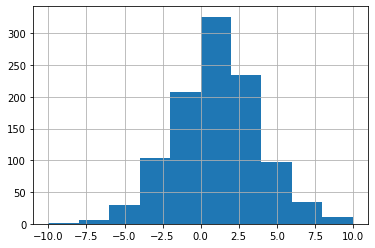

In [13]:
countSelections = selected_item_interactions.groupby(["participation","iteration","result_layout","variant"]).count()[["data"]]
countSelections.columns = ["count_selected"]
countSelections = countSelections.reset_index(3)
v0 = countSelections.loc[countSelections.variant==0]
v1 = countSelections.loc[countSelections.variant==1]
variant_joined = v0.join(v1, how="outer", rsuffix="_v1")
variant_joined.fillna(0, inplace=True)
variant_joined["difference"] = variant_joined["count_selected"] - variant_joined["count_selected_v1"] 
variant_joined["difference"].hist()

### Mean volumes of selected items and its differences per layout and displayed page

In [14]:
print(variant_joined.groupby("result_layout").mean()[["count_selected","count_selected_v1","difference"]].round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  count\_selected &  count\_selected\_v1 &  difference \\
result\_layout         &                 &                    &             \\
\midrule
column-single         &            3.51 &               3.05 &        0.46 \\
columns               &            3.43 &               2.97 &        0.47 \\
max-columns           &            3.51 &               3.12 &        0.39 \\
row-single            &            3.56 &               2.82 &        0.74 \\
row-single-scrollable &            3.25 &               2.70 &        0.56 \\
rows                  &            3.82 &               3.00 &        0.82 \\
\bottomrule
\end{tabular}



In [15]:
contingency_table = pd.crosstab(selected_item_interactions.result_layout,selected_item_interactions.variant)
contingency_table

variant,0,1
result_layout,,
column-single,684,594
columns,632,546
max-columns,596,530
row-single,608,482
row-single-scrollable,491,407
rows,680,534


In [20]:
from statsmodels.stats.proportion import proportions_ztest
for i in howManyTimesDisplayed.index.unique(): 

    totX = (howManyTimesDisplayed.loc["row-single-scrollable"]*20).iloc[0]
    cX = contingency_table.loc["row-single-scrollable"].sum()

    totY = ( howManyTimesDisplayed.loc[i]*20).iloc[0]
    cY = contingency_table.loc[i].sum()

    succ = [cX, cY]
    nobs = [totX, totY]
    print(i,proportions_ztest(succ, nobs))

column-single (-3.0828688388854664, 0.002050154933851863)
columns (-2.167390173490592, 0.030205115907247705)
max-columns (-3.0725725652357356, 0.002122222279523051)
row-single (-2.627650596219978, 0.008597677589924939)
row-single-scrollable (0.0, 1.0)
rows (-4.753185046061361, 2.0023692505185135e-06)


In [296]:
for i in howManyTimesDisplayed.index.unique(): 

    totX = (howManyTimesDisplayed.loc["rows"]*20).iloc[0]
    cX = contingency_table.loc["rows"].sum()

    totY = ( howManyTimesDisplayed.loc[i]*20).iloc[0]
    cY = contingency_table.loc[i].sum()

    succ = [cX, cY]
    nobs = [totX, totY]
    print(i,proportions_ztest(succ, nobs))

column-single (1.8624442640738177, 0.0625404948081028)
columns (2.756295136655862, 0.005846022093083698)
max-columns (1.7246786610056313, 0.08458539872369006)
row-single (2.1654538844748017, 0.03035294333462778)
row-single-scrollable (4.753185046061361, 2.0023692505185135e-06)
rows (0.0, 1.0)


- Rows scroll has significantly less interactions w.r.t. all other layouts
- Rows double has sign. more interactions w.r.t. all but columns double layouts

### Stat tests while seeing the selection of disadvantaged variant as a Bernouli process

In [22]:
from statsmodels.stats.proportion import proportions_ztest
for i in contingency_table.index.unique():
    for j in contingency_table.index.unique():
        if i!=j:
            cx = contingency_table.loc[[i,j]]
            print(i,j, fisher_exact(cx, alternative="less"))

column-single columns (0.9948216340621404, 0.4905976096137806)
column-single max-columns (1.0239983729916615, 0.6294908906147381)
column-single row-single (0.9128787878787878, 0.14483234221033925)
column-single row-single-scrollable (0.9545145960624576, 0.312498664004568)
column-single rows (0.9042780748663102, 0.11332922127639353)
columns column-single (1.0052053209947946, 0.5416362267743974)
columns max-columns (1.0293286132212307, 0.6509225209819508)
columns row-single (0.9176306149990361, 0.16461938977407592)
columns row-single-scrollable (0.9594831509291795, 0.3370481642346971)
columns rows (0.9089851325145443, 0.1313744253361482)
max-columns column-single (0.9765640516385303, 0.4018381238879948)
max-columns columns (0.9715070456173871, 0.38045770856328015)
max-columns row-single (0.8914846077457795, 0.09620654667915134)
max-columns row-single-scrollable (0.9321446412788686, 0.23029620008926308)
max-columns rows (0.8830854605993341, 0.07288288245293045)
row-single column-single (1

In [298]:
contingency_table = pd.crosstab(selected_item_interactions.layout_high_level,selected_item_interactions.variant)
contingency_table

variant,0,1
layout_high_level,,
cols,1912,1670
rows,1779,1423


In [299]:
from scipy.stats import fisher_exact
fisher_exact(contingency_table, alternative="less")

(0.9157994298081745, 0.03784085549686131)

### Results
- disadvantaged variant is still considerably less represented, but the proportion is more equal
- overall, row-wise layouts are more imballanced than column-wise, but the differences between individual layout types are not significant

### Stat tests while considering the means of differences between selecting advantaged and disadvantaged var.

In [23]:
from scipy.stats import ttest_ind, ttest_rel
variant_joined = variant_joined.reset_index(2)
for i in variant_joined.result_layout.unique():
    for j in variant_joined.result_layout.unique():
        if i!=j:
            dx = variant_joined.loc[variant_joined.result_layout == i,"difference"]
            dy = variant_joined.loc[variant_joined.result_layout == j,"difference"] 
            print(i,j, ttest_ind(dx,dy))

row-single-scrollable columns Ttest_indResult(statistic=0.30718806777095303, pvalue=0.7588922423121107)
row-single-scrollable max-columns Ttest_indResult(statistic=0.5238317050477728, pvalue=0.600759335009639)
row-single-scrollable rows Ttest_indResult(statistic=-0.9257353510653028, pvalue=0.3552662180619234)
row-single-scrollable column-single Ttest_indResult(statistic=0.31845235243176867, pvalue=0.7503350836331034)
row-single-scrollable row-single Ttest_indResult(statistic=-0.5963132957990341, pvalue=0.551387536654957)
columns row-single-scrollable Ttest_indResult(statistic=-0.30718806777095303, pvalue=0.7588922423121107)
columns max-columns Ttest_indResult(statistic=0.2523558777567157, pvalue=0.800913290770198)
columns rows Ttest_indResult(statistic=-1.2473665265923977, pvalue=0.213073968006661)
columns column-single Ttest_indResult(statistic=0.0200997477237435, pvalue=0.9839744348008863)
columns row-single Ttest_indResult(statistic=-0.9028052568200596, pvalue=0.367244886411362)
max

- We're getting less significant results for this view on data

In [84]:
res = selected_item_interactions.groupby(["iteration"]).count()[["participation"]]
res.columns = ["selected_items"]
res

,selected_items
iteration,
1.0,882
2.0,892
3.0,846
4.0,831
5.0,837
6.0,813
7.0,843
8.0,840


- slight decrease in the selections after first 1-2 iterations

# Focus on the pair of the same items

In [26]:
def getMovieId(x):
    return x["movie_id"]

itemsDict = {"participation":[],
            "iteration":[],
            "layout_high_level":[],
            "results_layout":[],
            "order":[], 
            "algorithm":[], 
            "rank":[], 
            "movieID":[] 
            }

pageLoads = d.loc[d.interaction_type == "loaded-page"]

for idx, row in pageLoads.iterrows():
    dt = json.loads(row.data)
    page = dt["page"]
    if page == "compare_algorithms":
        deltaMovies = dt["context"]["extra"]["movies"]["delta"]["movies"]
        deltaOrder = dt["context"]["extra"]["movies"]["delta"]["order"]
        gammaMovies = dt["context"]["extra"]["movies"]["gamma"]["movies"]
        gammaOrder = dt["context"]["extra"]["movies"]["gamma"]["order"]
        
        deltaMIDs = list(map(getMovieId, deltaMovies))
        gammaMIDs = list(map(getMovieId, gammaMovies))
        
        for c, val in enumerate(deltaMIDs):
            itemsDict["participation"].append(row["participation"])
            itemsDict["iteration"].append(row["iteration"])
            itemsDict["layout_high_level"].append(row["layout_high_level"])
            itemsDict["results_layout"].append(row["result_layout"])
            itemsDict["order"].append(deltaOrder)
            itemsDict["algorithm"].append("delta")
            itemsDict["rank"].append(c)
            itemsDict["movieID"].append(val)
            
        for c, val in enumerate(gammaMIDs):
            itemsDict["participation"].append(row["participation"])
            itemsDict["iteration"].append(row["iteration"])
            itemsDict["layout_high_level"].append(row["layout_high_level"])
            itemsDict["results_layout"].append(row["result_layout"])
            itemsDict["order"].append(gammaOrder)
            itemsDict["algorithm"].append("gamma")
            itemsDict["rank"].append(c)
            itemsDict["movieID"].append(val)        


In [28]:
displayedItems = pd.DataFrame(itemsDict)
displayedItems.head()

,participation,iteration,layout_high_level,results_layout,order,algorithm,rank,movieID
0,36,1.0,rows,row-single-scrollable,0,delta,0,4993
1,36,1.0,rows,row-single-scrollable,0,delta,1,6539
2,36,1.0,rows,row-single-scrollable,0,delta,2,45722
3,36,1.0,rows,row-single-scrollable,0,delta,3,53125
4,36,1.0,rows,row-single-scrollable,0,delta,4,91542


In [29]:
displayedItemsLeft = displayedItems.loc[displayedItems.order == 0]
displayedItemsLeft = displayedItemsLeft.set_index(["participation","iteration","movieID"])[["layout_high_level","results_layout","algorithm","rank"]]
displayedItemsRight = displayedItems.loc[displayedItems.order == 1]
displayedItemsRight = displayedItemsRight.set_index(["participation","iteration","movieID"])[["algorithm","rank"]]

pairedItems = displayedItemsLeft.join(displayedItemsRight, how="inner", rsuffix="_r")
pairedItems["leftRightRankComparison"] = 0
pairedItems.loc[pairedItems["rank"] < pairedItems.rank_r, "leftRightRankComparison"] = -1
pairedItems.loc[pairedItems["rank"] > pairedItems.rank_r, "leftRightRankComparison"] = 1

pairedItems["leftRightRelaxed"] = 0
pairedItems.loc[pairedItems["rank"] - pairedItems.rank_r < -1, "leftRightRelaxed"] = -1
pairedItems.loc[pairedItems["rank"] - pairedItems.rank_r > 1, "leftRightRelaxed"] = 1

pairedItems["rankDiff"] = pairedItems["rank"] - pairedItems["rank_r"] # positive values: better ranking of the right one

pairedItems.head()

layout_high_level         results_layout  \
participation iteration movieID                                            
36            1.0       6539                 rows  row-single-scrollable   
                        45722                rows  row-single-scrollable   
                        53125                rows  row-single-scrollable   
                        91542                rows  row-single-scrollable   
              2.0       86332                cols                columns   

                                algorithm  rank algorithm_r  rank_r  \
participation iteration movieID                                       
36            1.0       6539        delta     1       gamma       9   
                        45722       delta     2       gamma       0   
                        53125       delta     3       gamma       6   
                        91542       delta     4       gamma       8   
              2.0       86332       gamma     7       delta       1   

                                 leftRightRankComparison  leftRightRelaxed  \
participation iteration movieID                                              
36            1.0       6539                          -1                -1   
                        45722                          1                 1   
                        53125                         -1                -1   
                        91542                         -1                -1   
              2.0       86332                          1                 1   

                                 rankDiff  
participation iteration movieID            
36            1.0       6539           -8  
                        45722           2  
                        53125          -3  
                        91542          -4  
              2.0       86332           6

In [30]:
pairedItems.groupby("results_layout").count()

,layout_high_level,algorithm,rank,algorithm_r,rank_r,leftRightRankComparison,leftRightRelaxed,rankDiff
results_layout,,,,,,,,
column-single,376,376,376,376,376,376,376,376
columns,353,353,353,353,353,353,353,353
max-columns,378,378,378,378,378,378,378,378
row-single,382,382,382,382,382,382,382,382
row-single-scrollable,338,338,338,338,338,338,338,338
rows,378,378,378,378,378,378,378,378


In [31]:
pairedItems.groupby("leftRightRankComparison").count()

,layout_high_level,results_layout,algorithm,rank,algorithm_r,rank_r,leftRightRelaxed,rankDiff
leftRightRankComparison,,,,,,,,
-1,1008,1008,1008,1008,1008,1008,1008,1008
0,207,207,207,207,207,207,207,207
1,990,990,990,990,990,990,990,990


In [32]:
pairedItems.groupby("leftRightRelaxed").count()

,layout_high_level,results_layout,algorithm,rank,algorithm_r,rank_r,leftRightRankComparison,rankDiff
leftRightRelaxed,,,,,,,,
-1,785,785,785,785,785,785,785,785
0,620,620,620,620,620,620,620,620
1,800,800,800,800,800,800,800,800


In [33]:
sIt = selected_item_interactions[["participation","time","iteration","variant","movieID"]]
sIt = sIt.set_index(["participation","iteration","movieID"])
sIt.head()

time  variant
participation iteration movieID                                     
36            1.0       106489   2023-01-15 23:15:59.742434        0
                        5952     2023-01-15 23:16:00.293013        0
                        7153     2023-01-15 23:16:00.636370        0
                        98809    2023-01-15 23:16:02.500438        0
                        135143   2023-01-15 23:16:09.472159        1

In [34]:
pairedSelectedItems = pairedItems.join(sIt, how="inner", rsuffix="_selected")
pairedSelectedItems.head()

layout_high_level results_layout algorithm  \
participation iteration movieID                                              
36            2.0       91500                cols        columns     gamma   
                        106487               cols        columns     gamma   
                        116823               cols        columns     gamma   
                        118696               cols        columns     gamma   
                        135133               cols        columns     gamma   

                                 rank algorithm_r  rank_r  \
participation iteration movieID                             
36            2.0       91500       4       delta       3   
                        106487      2       delta       4   
                        116823      3       delta       5   
                        118696      0       delta       2   
                        135133      1       delta       6   

                                 leftRightRankComparison  leftRightRelaxed  \
participation iteration movieID                                              
36            2.0       91500                          1                 0   
                        106487                        -1                -1   
                        116823                        -1                -1   
                        118696                        -1                -1   
                        135133                        -1                -1   

                                 rankDiff                        time  variant  
participation iteration movieID                                                 
36            2.0       91500           1  2023-01-15 23:16:42.091374        0  
                        106487         -2  2023-01-15 23:16:41.575220        0  
                        116823         -2  2023-01-15 23:16:41.047739        0  
                        118696         -2  2023-01-15 23:16:38.416542        0  
                        135133         -5  2023-01-15 23:16:39.745823        0

In [35]:
pairedSelectedItems.shape

(999, 11)

### Almost 1000 items selected from the ones mutually recommended

In [36]:
contingency_table = pd.crosstab(pairedSelectedItems.layout_high_level,pairedSelectedItems.variant)
contingency_table

variant,0,1
layout_high_level,,
cols,334,151
rows,425,89


In [37]:
from scipy.stats import fisher_exact
fisher_exact(contingency_table)

(0.4632021815348656, 4.1105078850897253e-07)

## Results
- if only the items present in both recommenders are considered, column-wise variants have more uniform distribution of clicks

In [38]:
contingency_table = pd.crosstab(pairedSelectedItems.results_layout,pairedSelectedItems.variant)
contingency_table

variant,0,1
results_layout,,
column-single,117,67
columns,108,51
max-columns,109,33
row-single,141,30
row-single-scrollable,108,33
rows,176,26


In [39]:
(contingency_table.iloc[:,1] / (contingency_table.iloc[:,0]+contingency_table.iloc[:,1])).round(3)*100

results_layout
column-single            36.4
columns                  32.1
max-columns              23.2
row-single               17.5
row-single-scrollable    23.4
rows                     12.9
dtype: float64

In [40]:
from statsmodels.stats.proportion import proportions_ztest
for i in contingency_table.index.unique():
    for j in contingency_table.index.unique():
        if i!=j:
            cx = contingency_table.loc[[i,j]]
            print(i,j, fisher_exact(cx, alternative="less"))            

column-single columns (0.8246268656716418, 0.23306997953375075)
column-single max-columns (0.5286868410242366, 0.007098853613186374)
column-single row-single (0.37154652270562083, 4.728872406494491e-05)
column-single row-single-scrollable (0.5335820895522388, 0.00792353274235814)
column-single rows (0.25797150610583447, 4.7470841858602757e-08)
columns column-single (1.2126696832579185, 0.830748707225023)
columns max-columns (0.6411225040474906, 0.05701609016593095)
columns row-single (0.45056320400500627, 0.0016166491281912818)
columns row-single-scrollable (0.6470588235294118, 0.06136728798631163)
columns rows (0.31283422459893045, 8.821311501248819e-06)
max-columns column-single (1.8914788914788916, 0.9965250821134732)
max-columns columns (1.5597643097643097, 0.9671029617563964)
max-columns row-single (0.7027724049000644, 0.13367370887794666)
max-columns row-single-scrollable (1.0092592592592593, 0.5687951769338729)
max-columns rows (0.48794765840220383, 0.009340523752147941)
row-sin

## Results
- results for column-single are significantly better than all other layouts except for Columns:double. Columns double is sign. better than 2 of 3 row-wise layouts; rows double is sign. worse than all but rows: single

In [43]:
contingency_table = pd.crosstab(pairedSelectedItems.leftRightRelaxed,pairedSelectedItems.variant)
contingency_table

variant,0,1
leftRightRelaxed,,
-1,307,61
0,218,67
1,234,112


In [44]:
disadv = pairedSelectedItems.loc[pairedSelectedItems.variant==1].groupby(["layout_high_level","leftRightRelaxed"])[["algorithm"]].count()
allData = pairedSelectedItems.groupby(["layout_high_level","leftRightRelaxed"])[["algorithm"]].count()
disadv / allData

algorithm
layout_high_level leftRightRelaxed           
cols              -1                 0.202247
                   0                 0.316547
                   1                 0.422619
rows              -1                 0.131579
                   0                 0.157534
                   1                 0.230337

In [45]:
proportions_ztest(disadv.loc[[("cols",-1),("cols",1)],"algorithm"], allData.loc[[("cols",-1),("cols",1)],"algorithm"])

(-4.432696355299683, 9.30618842124412e-06)

In [46]:
proportions_ztest(disadv.loc[[("rows",-1),("rows",1)],"algorithm"], allData.loc[[("rows",-1),("rows",1)],"algorithm"])

(-2.467789631920335, 0.013595018961757379)

In [47]:
disadv = pairedSelectedItems.loc[pairedSelectedItems.variant==1].groupby(["results_layout","leftRightRelaxed"])[["algorithm"]].count()
allData = pairedSelectedItems.groupby(["results_layout","leftRightRelaxed"])[["algorithm"]].count()
disadv / allData

algorithm
results_layout        leftRightRelaxed           
column-single         -1                 0.216216
                       0                 0.358491
                       1                 0.561404
columns               -1                 0.240741
                       0                 0.320000
                       1                 0.400000
max-columns           -1                 0.140000
                       0                 0.250000
                       1                 0.303571
row-single            -1                 0.183333
                       0                 0.113636
                       1                 0.208955
row-single-scrollable -1                 0.186441
                       0                 0.250000
                       1                 0.277778
rows                  -1                 0.042254
                       0                 0.148649
                       1                 0.210526

## Results
- for column-based layouts, the better ranking of item for disadvantaged algorithm considerably increases its chance to be selected
- the magnitude is much lower for row-based designs

# Considering sequence of clicks, how does the (dis)advantaged method performs?

In [48]:
selected_item_interactions["selectionOrder"] = selected_item_interactions.groupby(["participation","iteration"])["time"].rank(method="dense", ascending=True)
selected_item_interactions

,participation,interaction_type,time,data,iteration,result_layout,GAMMA,DELTA,variant,layout_high_level,movieID,selectionOrder
id,,,,,,,,,,,,
3271,36,selected-item,2023-01-15 23:15:59.742434,"{""selected_item"": {""genres"": [""Adventure"", ""Fa...",1.0,row-single-scrollable,1.0,0.0,0,rows,106489,1.0
3272,36,selected-item,2023-01-15 23:16:00.293013,"{""selected_item"": {""genres"": [""Adventure"", ""Fa...",1.0,row-single-scrollable,1.0,0.0,0,rows,5952,2.0
3273,36,selected-item,2023-01-15 23:16:00.636370,"{""selected_item"": {""genres"": [""Action"", ""Adven...",1.0,row-single-scrollable,1.0,0.0,0,rows,7153,3.0
3274,36,selected-item,2023-01-15 23:16:02.500438,"{""selected_item"": {""genres"": [""Adventure"", ""Fa...",1.0,row-single-scrollable,1.0,0.0,0,rows,98809,4.0
3277,36,selected-item,2023-01-15 23:16:09.472159,"{""selected_item"": {""genres"": [""Fantasy""], ""mov...",1.0,row-single-scrollable,1.0,0.0,1,rows,135143,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
47768,261,selected-item,2023-02-05 18:46:36.414297,"{""selected_item"": {""genres"": [""Action"", ""Fanta...",7.0,columns,0.0,1.0,1,cols,65682,4.0
47770,261,selected-item,2023-02-05 18:46:39.183100,"{""selected_item"": {""genres"": [""Action"", ""Adven...",7.0,columns,0.0,1.0,1,cols,86332,5.0
47783,261,selected-item,2023-02-05 18:46:58.865334,"{""selected_item"": {""genres"": [""Adventure"", ""An...",8.0,max-columns,0.0,1.0,0,cols,90647,1.0


In [49]:
vals = []
for k in range(1,10):

    dt = selected_item_interactions.loc[selected_item_interactions.selectionOrder == k].groupby("variant")["data"].count()
    print(dt[1] / (dt[0]+dt[1]))

0.17495219885277247
0.29574678536102866
0.34725274725274724
0.40786240786240785
0.49714285714285716
0.6095076400679117
0.6730769230769231
0.6986301369863014
0.7158273381294964


In [50]:
vals = []
for k in range(1,10):

    dt = selected_item_interactions.loc[selected_item_interactions.selectionOrder <= k].groupby("variant")["data"].count()
    print(dt[1] / (dt[0]+dt[1]))

0.17495219885277247
0.23432182790471562
0.268958543983822
0.2988627347262629
0.3298370899352823
0.36232741617357
0.38858793788371254
0.407758766728782
0.4216146254651351


In [51]:
selected_item_interactions.loc[selected_item_interactions.selectionOrder <= k].groupby(["variant", "result_layout"])["data"].count()

variant  result_layout        
0        column-single            641
         columns                  610
         max-columns              577
         row-single               592
         row-single-scrollable    480
         rows                     675
1        column-single            530
         columns                  486
         max-columns              446
         row-single               387
         row-single-scrollable    342
         rows                     415
Name: data, dtype: int64

In [52]:
dct = {}

for k in range(1,10):
    dt = selected_item_interactions.loc[selected_item_interactions.selectionOrder <= k]
    dtDisadv = dt.loc[dt.variant == 1].groupby("result_layout")["data"].count()
    dtAll = dt.groupby("result_layout")["data"].count()
    dct[k] = (dtDisadv/dtAll)
    
resIncremental = pd.DataFrame(dct)    
resIncremental.round(3)*100

,1,2,3,4,5,6,7,8,9
result_layout,,,,,,,,,
column-single,23.2,30.7,34.2,37.1,39.2,42.1,44.0,44.9,45.3
columns,22.8,26.4,29.1,31.6,34.1,37.5,40.5,42.7,44.3
max-columns,19.4,25.5,30.2,33.9,37.2,39.9,41.4,42.8,43.6
row-single,14.1,20.9,23.7,26.0,28.3,31.1,34.5,37.5,39.5
row-single-scrollable,15.2,20.6,24.2,29.2,33.5,36.6,38.8,40.3,41.6
rows,9.0,15.1,18.8,20.6,24.9,29.5,33.2,35.7,38.1


### Significance for the selection of first 3 items

In [53]:
first_3_selections = selected_item_interactions.loc[selected_item_interactions.selectionOrder <= k]
contingency_table = pd.crosstab(first_3_selections.result_layout,first_3_selections.variant)

from scipy.stats import fisher_exact
for i in contingency_table.index.unique():
    for j in contingency_table.index.unique():
        if i!=j:
            cx = contingency_table.loc[i]
            cy = contingency_table.loc[j]
            contTable = [[cx[1],cx[0]],[cy[1],cy[0]]]
            print(i,j, fisher_exact(contTable, alternative="greater"))

column-single columns (1.0377945982036811, 0.3458254708189081)
column-single max-columns (1.0696921150388616, 0.22997747715459754)
column-single row-single (1.2648195850314632, 0.004225228826366799)
column-single row-single-scrollable (1.1604674713304322, 0.05777179886277374)
column-single rows (1.3448489746818788, 0.00031090079680843035)
columns column-single (0.9635818125579957, 0.6847878562543691)
columns max-columns (1.0307358670881424, 0.3814166748526532)
columns row-single (1.2187571483034694, 0.014880015222145585)
columns row-single-scrollable (1.1182053494391717, 0.12481690505290328)
columns rows (1.2958720126407268, 0.0016665710533943145)
max-columns column-single (0.9348484353029659, 0.7953299786671166)
max-columns columns (0.9701806562965816, 0.6514900958927297)
max-columns row-single (1.1824146100072102, 0.03589221651009762)
max-columns row-single-scrollable (1.084861199793244, 0.20838672010492015)
max-columns rows (1.2572299597001524, 0.005568726894543064)
row-single colum

<AxesSubplot:>

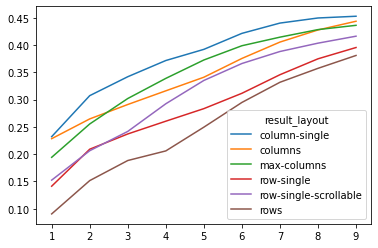

In [54]:
resIncremental.T.plot()

In [55]:
dct = {}

for k in range(1,10):
    dt = selected_item_interactions.loc[selected_item_interactions.selectionOrder == k]
    dtDisadv = dt.loc[dt.variant == 1].groupby("result_layout")["data"].count()
    dtAll = dt.groupby("result_layout")["data"].count()
    dct[k] = (dtDisadv/dtAll)
    
resIncremental = pd.DataFrame(dct)    
resIncremental.round(3)

,1,2,3,4,5,6,7,8,9
result_layout,,,,,,,,,
column-single,0.232,0.385,0.419,0.477,0.500,0.645,0.637,0.581,0.519
columns,0.228,0.302,0.350,0.407,0.472,0.630,0.741,0.787,0.792
max-columns,0.194,0.317,0.407,0.477,0.552,0.590,0.584,0.625,0.592
row-single,0.141,0.279,0.303,0.346,0.415,0.527,0.716,0.825,0.857
row-single-scrollable,0.152,0.264,0.325,0.478,0.574,0.630,0.661,0.683,0.742
rows,0.090,0.214,0.269,0.270,0.480,0.629,0.697,0.721,0.833


<AxesSubplot:>

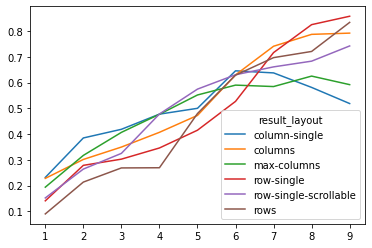

In [56]:
resIncremental.T.plot()

## What if we consider also paired items in low-level feedback

In [158]:
gbr.reset_index(2).groupby("variant").mean()

C:\Users\lpeska\AppData\Local\Temp\ipykernel_2632\1107655512.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gbr.reset_index(2).groupby("variant").mean()


,selectedCount,selectedWithPaired,userNormSelected,userNormSelectedWithPaired,rating
variant,,,,,
0,3.419083,3.641721,0.295603,0.057063,3.123480
1,2.879326,3.585594,-0.248012,-0.003566,3.081384


In [159]:
gbrx = gbr.reset_index(2)
dx = variant_joined["selectedWithPaired"]
dy = variant_joined["selectedWithPaired_v1"]

ttest_rel(dx,dy)

Ttest_relResult(statistic=0.7202764455178461, pvalue=0.47151196925143335)

In [160]:
gbrx.groupby(["result_layout","variant"])[["selectedCount","selectedWithPaired"]].sum()

selectedCount  selectedWithPaired
result_layout         variant                                   
column-single         0                677.0               744.0
                      1                588.0               703.0
columns               0                627.0               676.0
                      1                546.0               654.0
max-columns           0                582.0               615.0
                      1                527.0               632.0
row-single            0                610.0               640.0
                      1                485.0               634.0
row-single-scrollable 0                490.0               523.0
                      1                407.0               515.0
rows                  0                669.0               695.0
                      1                525.0               695.0

In [161]:
contingency_table = pd.crosstab(selected_item_interactions.layout_high_level,selected_item_interactions.variant)
contingency_table

variant,0,1
layout_high_level,,
cols,1912,1670
rows,1779,1423


# Are all sources of participants the same?

In [162]:
df_completed_participation.groupby("user_study_id").count()
df_completed_participation["source"] = "organic"
df_completed_participation.loc[df_completed_participation.user_study_id == 14, "source"] = "proliferic"
dfcp = df_completed_participation[["source"]]
rating_data = rating_data.join(dfcp, on="participation")

C:\Users\lpeska\AppData\Local\Temp\ipykernel_2632\3338431009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_completed_participation["source"] = "organic"


In [163]:
rating_data.groupby(["source","result_layout","variant"])[["rating"]].mean()

rating
source     result_layout         variant          
organic    column-single         0        3.078431
                                 1        3.068627
           columns               0        3.086957
                                 1        2.967391
           max-columns           0        3.151163
                                 1        3.162791
           row-single            0        2.987179
                                 1        3.102564
           row-single-scrollable 0        3.064103
                                 1        3.089744
           rows                  0        3.315789
                                 1        3.210526
proliferic column-single         0        3.031250
                                 1        2.916667
           columns               0        3.200000
                                 1        3.105263
           max-columns           0        3.091954
                                 1        3.126437
           row-single            0        3.127660
                                 1        3.042105
           row-single-scrollable 0        3.172840
                                 1        3.137500
           rows                  0        3.182692
                                 1        3.096154

In [164]:
dx = rating_data.loc[((rating_data.source=="proliferic") & (rating_data.variant==0)),"rating"]
dy = rating_data.loc[((rating_data.source=="proliferic") & (rating_data.variant==1)),"rating"]
ttest_ind(dx,dy)

Ttest_indResult(statistic=0.9252371640215401, pvalue=0.35504329732965256)

In [165]:
gbrx = gbr.reset_index().join(dfcp, on="participation")
gbrx.groupby(["source","variant"])[["selectedCount","selectedWithPaired"]].mean()

selectedCount  selectedWithPaired
source     variant                                   
organic    0             3.193359            3.378906
           1             2.615234            3.363281
proliferic 0             3.626571            3.883303
           1             3.122083            3.789946

In [166]:
relative_comparison_data = relative_comparison_data.join(dfcp, on="participation")

In [167]:
rcgb = relative_comparison_data.groupby(["relative_comparison_numeric","source"]).count()[["relative_comparison"]]
#succ = rcgb.loc[-2,"relative_comparison"]+rcgb.loc[-1,"relative_comparison"]
#fail = rcgb.loc[1,"relative_comparison"]+rcgb.loc[2,"relative_comparison"]
#print(binom_test(succ, succ+fail,p=0.5,alternative='greater'))
rcgb

relative_comparison
relative_comparison_numeric source                         
-2                          organic                      50
                            proliferic                   71
-1                          organic                     121
                            proliferic                  140
 0                          organic                     163
                            proliferic                  153
 1                          organic                     131
                            proliferic                  128
 2                          organic                      44
                            proliferic                   62

In [168]:
succ = rcgb.loc[(-2,"proliferic"),"relative_comparison"]+rcgb.loc[(-1,"proliferic"),"relative_comparison"]
fail = rcgb.loc[(1,"proliferic"),"relative_comparison"]+rcgb.loc[(2,"proliferic"),"relative_comparison"]
print(binom_test(succ, succ+fail,p=0.5,alternative='greater'))

0.15895762856145837


In [169]:
contingency_table = pd.crosstab(relative_comparison_data.source,relative_comparison_data.relative_comparison_numeric)
contingency_table

relative_comparison_numeric,-2,-1,0,1,2
source,,,,,
organic,50,121,163,131,44
proliferic,71,140,153,128,62
